In [1]:
%matplotlib inline

import ipykernel
import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc
from scipy.interpolate import interp1d, interp2d
from scipy import stats
from matplotlib.colors import LogNorm
                                                                                                                                                                                                                                

from scipy import sparse
from sklearn.mixture import GMM

from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=20)


Isochrones

I noticed that there is now an option on the web-interface of the padova isochrones to 
download the Gaia and 2MASS filters together. 

In [5]:
isochrone2MASS = '../IsoFit/padovaJHKAv025Z002.fits'
isochroneGaia = '../IsoFit/padovaGaiaAv025Z002.fits'

photo2MASS = fits.open(isochrone2MASS)
photo2MASS = photo2MASS[1].data
photoGaia = fits.open(isochroneGaia)
photoGaia = photoGaia[1].data 

Data

In [6]:
hdu = fits.open('/data1/Data/Zari+17/gaia_inside_contour.fits')
data = hdu[1].data

In [7]:
flux_error =  data['phot_g_mean_flux_error']
flux = data['phot_g_mean_flux']
Gmag = data['phot_g_mean_mag']
Jmag = data['j_m']
G0=25.525
sigmaG0 = 0.003
sigmaGmag = np.sqrt((1.0857*(flux_error/flux))**2. + sigmaG0**2.)
sigmaJ = data['j_msigcom']
sigmaGminj = np.sqrt(sigmaGmag**2. + sigmaJ**2.) 

Fit 

Remember to compile firts the functions below.

The notation follows Jorgensen & Lindegren (2005).

In [ ]:
ages = np.arange(6., 8.5, 0.01)
N = len(data)
plx = 2.65
d = 1000./plx
mu = 5*np.log10(d) - 5

gAbsStar = Gmag - mu
gminjStar = Gmag - Jmag
gfSmooth, gf = determineClusterAge(gAbsStar, gminjStar, sigmaGmag, sigmaGminj,
                                   isochrone2MASS, isochroneGaia, ages, N)

Compute Ages.

The age is defined as the maximum of the posterior.

Sometimes there are Values Errors (when the posteriors are flat). In this case the age is undetermined (and I set it to 0).

In [10]:
ids = data['source_id']
singleAges = np.zeros(len(gf))
for i in range(len(gf)):
        try:
            singleAges[i] = ages[np.where(gf[i] == np.max(gf[i]))]
        except ValueError:
            print(ids[i])
            singleAges[i] = 0.


2999104817312958592
3215584466249609088
3217480260518089344
3216922636325083264
3218451850841074816
3217144806393124096
3216015023834943616
3216729568954934784
3216100235987793408
3012575445364909056
3022675421738055936
3023421715255871616
3023464905446860544
3218740889254482432
3219676122677918976


In [11]:
gfNorm = np.zeros((len(gf), len(ages)))
for i in range(len(gf)):
    
    indx = np.where(gf[i] == np.max(gf[i]))
    ### Use numerical precision to exclude stars with very small posteriors
    t = 10**-15
    
    if (gf[i, indx][0,0]) >= t:
        gfNorm[i, :] = gf[i, :]/np.max(gf[i, :])
    else: 
        gfNorm[i, :] = 0.
        
indxGood,  indxBad = computeGoodG(gfNorm, ages, ids)


Value Error at star: 3217143638170095360
Value Error at star: 3218706563876063488
Value Error at star: 3217143642456397568
Value Error at star: 2999104817312958592
Value Error at star: 3215646584360557184
Value Error at star: 2997554913938144000
Value Error at star: 3215584466249609088
Value Error at star: 3217054612079318272
Value Error at star: 3022321241555635072
Value Error at star: 3214087751750332032
Value Error at star: 3209850891067691904
Value Error at star: 3209916135915438464
Value Error at star: 3017347394550378880
Value Error at star: 3215709806280245120
Value Error at star: 3209643010355248896
Value Error at star: 3209598793667478144
Value Error at star: 3209846420008479360
Value Error at star: 3017386397153979392
Value Error at star: 3210667725127921792
Value Error at star: 3209581648157181312
Value Error at star: 3015775990569271168
Value Error at star: 3016558602329857280
Value Error at star: 3016492661697622144
Value Error at star: 3016256404135887744
Value Error at s

Value Error at star: 3216106248941653888
Value Error at star: 3216707338204216320
Value Error at star: 3216710155702761600
Value Error at star: 2997642531271075968
Value Error at star: 2997643768221655552
Value Error at star: 2997643699502179200
Value Error at star: 3213501231016674176
Value Error at star: 3218511464985872384
Value Error at star: 2998761559231003392
Value Error at star: 2999078871413822848
Value Error at star: 3209797319939978112
Value Error at star: 3218487997284570496
Value Error at star: 3019613969050008832
Value Error at star: 3210713281845014144
Value Error at star: 2999016714647774720
Value Error at star: 3210493826196555520
Value Error at star: 3210493242081003136
Value Error at star: 3210341028439814144
Value Error at star: 3209902735621010688
Value Error at star: 3210575636733825024
Value Error at star: 3016772006370153216
Value Error at star: 3016770597620881920
Value Error at star: 3209859923383230336
Value Error at star: 3214265254158536576
Value Error at s

Value Error at star: 3022675421738055936
Value Error at star: 3220243367598582016
Value Error at star: 3022683358838511872
Value Error at star: 3024574518837382912
Value Error at star: 3022277913924875264
Value Error at star: 3022678823352153600
Value Error at star: 3022665010737331840
Value Error at star: 3024246520775273856
Value Error at star: 3023473014344779648
Value Error at star: 3220645754495509504
Value Error at star: 2999028019001698432
Value Error at star: 3022306673025880576
Value Error at star: 3023193085556785152
Value Error at star: 3023422539889590784
Value Error at star: 3023183877146419072
Value Error at star: 3220327617677038720
Value Error at star: 3220272504656708608
Value Error at star: 3023133402690920832
Value Error at star: 3022680197741686144
Value Error at star: 3022669889820178176
Value Error at star: 3220268656366016256
Value Error at star: 3220230998093927552
Value Error at star: 3220325899690124416
Value Error at star: 3023421715255871616
Value Error at s

Save

In [13]:
### Save in a .fits file 
### Note the format of the source id!

path = '/data1/Data/Zari+17/'
filename = 'bayesAgeEstimate_prlxConstant_Bad.fits'

colAges = fits.Column(name='ages', format='D', array= singleAges[indxBad])
colL = fits.Column(name='l', format='D', array= data['l'][indxBad])
colB = fits.Column(name='b', format='D', array= data['b'][indxBad])
colID  = fits.Column(name='sourceId', format='K', array= data['source_id'][indxBad])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename)

filename = 'bayesAgeEstimate_prlxConstant_Good.fits'

colAges = fits.Column(name='ages', format='D', array= singleAges[indxGood])
colL = fits.Column(name='l', format='D', array= data['l'][indxGood])
colB = fits.Column(name='b', format='D', array= data['b'][indxGood])
colID  = fits.Column(name='sourceId', format='K', array= data['source_id'][indxGood])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename)

Plot CMD (start from the saved files).



In [36]:
hduAgesGood = fits.open('/data1/Data/Zari+17/bayesAgeEstimate_prlxConstant_Good.fits')
dataAgesGood = hduAgesGood[1].data
lG, bG = dataAgesGood['l'], dataAgesGood['b']
singleAgesG = dataAgesGood['ages']
sourceIdG = dataAgesGood['sourceId']

In [37]:
hduAgesBad = fits.open('/data1/Data/Zari+17/bayesAgeEstimate_prlxConstant_Bad.fits')
dataAgesBad = hduAgesBad[1].data
lB, bB = dataAgesBad['l'], dataAgesBad['b']
singleAgesB = dataAgesBad['ages']
sourceIdB = dataAgesBad['sourceId']

In [40]:
sourceIdAll = data['source_id']
indxG = np.in1d(sourceIdAll, sourceIdG)
indxB = np.in1d(sourceIdAll, sourceIdB)

In [41]:
gminj = data['phot_g_mean_mag']-data['j_m']
gmag = data['phot_g_mean_mag']

gminjGood = gminj[indxG]
gmagGood = gmag[indxG]

gminjBad = gminj[indxB]
gmagBad = gmag[indxB]

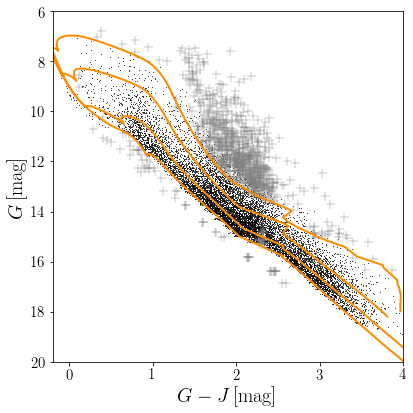

In [45]:

plx = 2.65
d = 1000./plx
mu = 5*np.log10(d) - 5

rc('font', family='serif', weight = 'normal', size=15)
plt.figure(figsize=(6, 6))
plt.plot(gminjGood[singleAgesG <= 7.3],
         gmagGood[singleAgesG <= 7.3],
         'ko', ms =0.8, markeredgecolor = 'None')
plt.plot(gminjBad, gmagBad, '+', color = 'gray',
         ms =9, mew = 0.4, alpha =1)
plt.axis([-0.2, 4., 20., 6])

isoage= [6.,6.5, 7., 7.3]
for a in isoage:
    
    wG = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]
    wM = [np.round(photoGaia['log(age/yr)'],3) == np.round(a,3)]

    gmagI = photoGaia['G'][wG]
    jmagI = photo2MASS['J'][wM]
    gminjI = gmagI-jmagI


    plt.plot(gminjI, gmagI + mu, '-', color = 'DarkOrange', lw = 2)

    plt.xlabel(r'$G-J \, \mathrm{[mag]}$', fontsize = 20)
    
plt.ylabel(r'$G \, \mathrm{[mag]}$', fontsize = 20)
plt.tight_layout()


Make Age maps

In [19]:
### Read fits file

hduAges = fits.open('/data1/Data/Zari+17/bayesAgeEstimate_prlxConstant_Good.fits')
dataAges = hduAges[1].data
l, b = dataAges['l'], dataAges['b']
singleAges = dataAges['ages']
sourceId = dataAges['sourceId']

In [20]:
ageBinsyrs = np.array([1.,3., 5., 7., 9., 11.,13,  15., 20., 200])*10**6.
ageBins = np.log10(ageBinsyrs)

In [21]:
from sklearn.neighbors import KernelDensity


lSel, bSel = dict(), dict()
sourceIdSel = dict()
singleAgesSel = dict()
log_dens_field = dict()


for i in range(len(ageBins)-1):
        w = np.where((singleAges >= ageBins[i]) & (singleAges < ageBins[i+1]))
        print(len(l[w]))
        lSel[i], bSel[i] = l[w], b[w]
        sourceIdSel[i] = sourceId[w]
        singleAgesSel[i] = singleAges[w]
        xmin, xmax = 190.,220.
        ymin, ymax = -30.,-5.

        X = np.vstack([lSel[i], bSel[i]]).T
        deg2rad = np.pi/180. 
        X = X*deg2rad
        kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(X)

        Xsamples = np.linspace(xmin, xmax, 300)
        Ysamples = np.linspace(ymin, ymax, 250)
        X,Y = np.meshgrid(Xsamples, Ysamples)
        grid = np.vstack([X.ravel(), Y.ravel()]).T
        grid = grid*deg2rad
        log_dens_field[i]= kde.score_samples(grid).T
        log_dens_field[i] = log_dens_field[i].reshape(X.shape)
    

2236
1396
1305
1244
1107
1023
953
2046
11764


And plot!

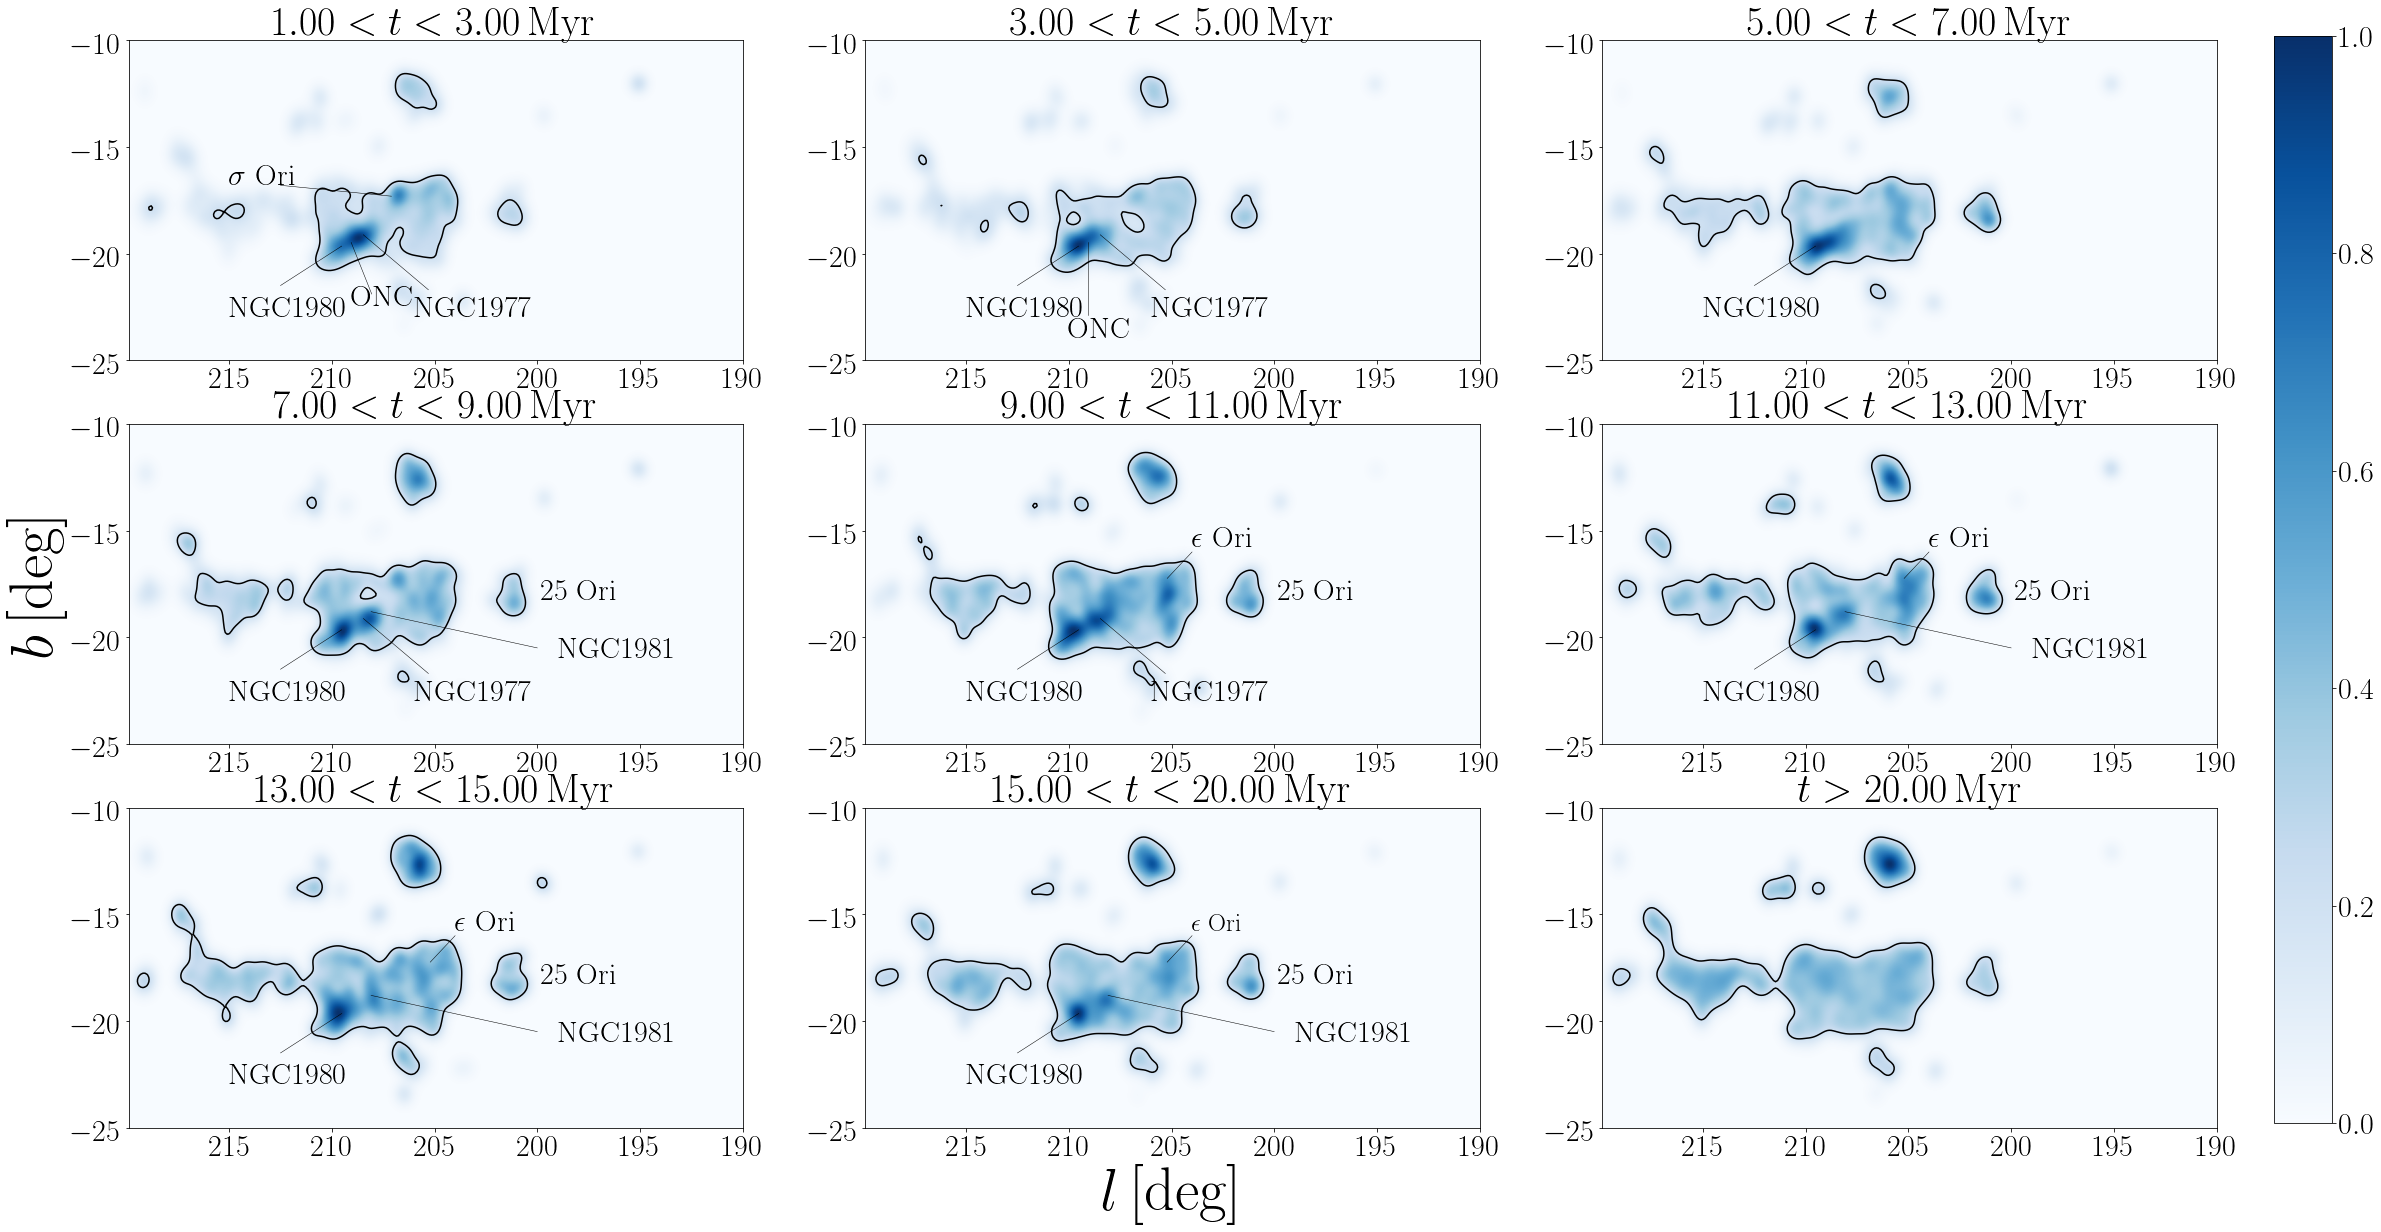

In [84]:
rc('font', family='serif', weight = 'normal', size=30)
xmin, xmax = 190., 220.
ymin, ymax = -30., -5.

fig = plt.figure(figsize=(40, 20))

for a in range(len(ageBins)-1):
    
    plt.subplot(3,3,a+1)
    im = plt.imshow(np.exp(log_dens_field[a])/np.max(np.exp(log_dens_field[a])),
                    extent = [xmin, xmax, ymin, ymax],
                    cmap=plt.cm.Blues,
                    aspect = 'auto',
                    origin = 'lower', interpolation = 'gaussian')
    plt.contour(np.exp(log_dens_field[a])/np.max(np.exp(log_dens_field[a])),
            cmap = plt.cm.gray,
            extent=[xmin, xmax, ymin, ymax],
            levels = [0.2], lw = 1)
    
    if a == 3:
        plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 60)
    elif a == 7:
        plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 60)
    
    if a <= 7:
        plt.title(r' $%.2f < t  < %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6., 10**ageBins[a+1]/10**6), 
             fontsize = 40) 
    elif a ==8:
        plt.title(r' $ t  > %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6.), 
             fontsize = 40)     
        
    if a == 0:
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(209.06, -22.5, 'ONC', fontsize = 30, family ='sans-serif')
        plt.plot([208.06, 209.06], [-21.9, -19.48], 'k-', lw = 0.5)
        plt.text(215, -16.8, '$\mathrm{\sigma}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 207.1], [-16.8, -17.31], 'k-', lw = 0.5)
        #plt.text(196.5, -10.7 , '$\mathrm{\lambda}$ Ori', fontsize = 25, family ='sans-serif')
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
    elif a == 1:
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        plt.text(210.06, -24, 'ONC', fontsize = 30, family ='sans-serif')
        plt.plot([209.06, 209.06], [-22.9, -19.48], 'k-', lw = 0.5)
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        
        
    
    elif  (a == 2):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        
    elif (a == 3):
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)
        
        
        
    elif (a==4):
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        plt.text(206, -23. , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([205.3, 208.47], [-21.7, -19.12], 'k-', lw = 0.5)
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        
        
    elif (a == 6):  
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        #plt.text(206, -24. , 'NGC1977', fontsize = 30, family ='sans-serif')
        #plt.plot([205.3, 208.47], [-22.7, -19.12], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)
        
        
    elif (a==5):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        

    elif (a==7):
        plt.text(215., -23., 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([212.5, 209.52], [-21.5, -19.65], 'k-', lw = 0.5)
        plt.text(199.8, -18.29, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.8, '$\mathrm{\epsilon}$ Ori', fontsize = 25, family ='sans-serif')
        plt.plot([204., 205.21], [-16., -17.24] , 'k-', lw = 0.5)
        #plt.text(206, -24. , 'NGC1977', fontsize = 30, family ='sans-serif')
        #plt.plot([205.3, 208.47], [-22.7, -19.12], 'k-', lw = 0.5)
        plt.text(199, -21., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([200., 208.09], [-20.5, -18.8 ], 'k-', lw =0.5)

    
    plt.axis([219.9, 190, -25, -10])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.128, 0.02, 0.755])
fig.colorbar(im, cax=cbar_ax)


Functions

In [1]:
### PURPOSE:
### Collection of functions to be used to perform a Bayesian isochrone fitting
### based on Jorgensen & Lindegren (2005).
### E.Z. Jan 2016



import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from statistics import mode


def likelihood(gmag_obs, gmag_teor, sigma_g, gminj_obs, gminj_teor,  sigma_gminj):
    
    """
    Likelihood function for a single star:
    
    Parameters:
    -------------
    gmag_obs, gminj_obs - observed Gmag and GminJ; 
    gmag_teor, gminj - array with predicted Gmag and GminJ values; Note that 
                gmag_teor=gmag_teor(m)
    sigma_g, sigma_gminj -  error on Gmag and GminJ;
    
    Returns:
    ----------
    l - array with the likelihood function for one star at fixed time and metallicity;
    
    """
    

  
    chisquared = np.zeros(len(gmag_teor))
    l = np.zeros(len(gmag_teor))
    for i in range(len(gmag_teor)):
        chisquared[i] = ((gmag_obs - gmag_teor[i])/sigma_g)**2. + \
                        ((gminj_obs - gminj_teor[i])/sigma_gminj)**2
        l[i] = (2.*np.pi*sigma_g*sigma_gminj)**(-1)*np.exp(-chisquared[i]/2.)
        
        
      
    return np.log(l)


def massprior(m, N, mmin, mmax):
    """
    Prior on the underlying mass distribution.
    
    Parameters:
    ------------
    m - array with the isochrone initial masses (units M_{\odot});
    N - number of stars;
    
    Returns:
    -----------
    mp - prior (Kroupa IMF with a = -2.7 (this is true for M > 1 M_{\odot}))
    
    Note that in principle the prior can also be not normalized.
    """
    a = 2.7
    gamma = 1. - a
    
    A = gamma*N/(mmax**gamma-mmin**gamma)
    mp = A*m**(-a)
    
    return np.log(mp)



def Gfunc(m, gmag_obs, gmag_teor, sigma_gmag, gminj_obs, gminj_teor, sigma_gminj, N, mmin, mmax):
    """
    Parameters:
    ------------
    m - array of the initial masses of the isochrone at a fixed time;
    Other parameters defined above.

    
    Returns:
    ------------
    G(t_j) as defined in equation 11 of Jorgensen and Lindegren (2005),
    without any dependency on the metallicity.
    """

    l = likelihood(gmag_obs, gmag_teor, sigma_gmag, gminj_obs, gminj_teor, sigma_gminj)
    G = np.zeros(len(m)+1)
   
    for i in range(len(m)-2):
        mp = massprior(m[i+1], N, mmin, mmax)
        G[i+1] = np.exp(l[i+1]+mp)*(m[i+2]-m[i])
    return np.sum(G)
    


    

def computeGoodG(gfNormalized, age, sourceId):
    """
    Parameters:
    -------------
    gfNormalized - array with the normalized G functions;
    age - isochrone ages
    
    Returns:
    -------------
    indexesGood, indexesBad - indexes of the "well-behaved" ("ill-behaved")
                              g-functions;
    
    
    
    """
    
    
    Glim = 0.6
    indexesGood, indexesGood2, indexesBad = [], [], []
    x1, x2 = [],[]
   
    for i in range(len(gfNormalized)):
        #print(i)
        
        function = interp1d(age, gfNormalized[i, :])
        n = 1000
        x = np.linspace(min(age), max(age), n)
        y = function(x)
        
        w = np.where(function(x) > Glim)
        x = x[w]
        y = y[w]
        
        try:
            indx = np.argmax(y)
            if (indx == len(y)-1) or (indx == 0):
                indexesBad.append(i)
                
            else:
                indexesGood.append(i)
           
        except ValueError:
            indexesBad.append(i)
            print("Value Error at star:", sourceId[i])
            pass
        
        
            
            
    return indexesGood, indexesBad


def determineClusterAge(gStar, gminjStar, gStar_error, 
                        gminj_error, isochrone2MASS, isochroneGaia, age, N):
    
    """
    Parameters:
    gStar, gminjStar: array of the observed quantities (G magnitude and G-J color);
    isochrone2MASS, isochroneGaia: strings with the isochrone considered;
    age: array of the ages where the posterior distribution is evaluated;
    N: total number of stars;
    
    Returns:
    gfNorm: array of the normalized G functions, which can then be multiplied or
            singularly averaged to get the age estimate.
    
    """
    
    photo2MASS = fits.open(isochrone2MASS)
    photo2MASS = photo2MASS[1].data
    photoGaia = fits.open(isochroneGaia)
    photoGaia = photoGaia[1].data 
    
    gf = np.zeros((len(gStar), len(age)))
    
    for a in range(len(age)):
        w = np.where(np.round(photo2MASS['log(age/yr)'],3) == np.round(age[a],3))
        gTeor = photoGaia['G'][w]
        gminjTeor = photoGaia['G'][w]-photo2MASS['J'][w]
        mTeor = photoGaia['M_ini'][w]
        
        mmin = np.min(mTeor)
        mmax = np.max(mTeor)

        print(a, age[a], len(mTeor))
        for i in range(len(gStar)):
            gf[i, a] = Gfunc(mTeor, 
                         gStar[i], 
                         gTeor,
                         gStar_error[i],
                         gminjStar[i], 
                         gminjTeor,
                         gminj_error[i], N, mmin, mmax)
        
    gfSmoothed = np.zeros((len(gStar),len(age)))
                      
    for i in range(len(gStar)):
        try:
            filtered = lowess((abs(gf[i, :])), age, is_sorted=True, frac=0.1, it=0)
            gfSmoothed[i, :] = filtered[:, 1]
        except ValueError:
            print("Value Error at star:", i, "when computing gfSmoothed")
            pass
            
        
    return gfSmoothed, gf
